# **Voices of the Customers: Analyzing Sentiment in Amazon Reviews**
**Written by Patrick Dasilva**

---

## **Objective**
>I will use machine learning classification algorithms to predict whether reviews left on amazon purchases are positive, neutral, or negative. 
## **Useful Applications**
>One application of my model is for companies who want to understand how their customers feel about their products. First, mass amounts of data regarding a product, feature, or experience can be scraped from social media sites (Twitter, Reddit, Facebook, etc.). Then, my model will predict the sentiment of those comments, and the company can draw conclusions based on that data.
## **Methods**
>I classify reviews with this simple criteria.
  - Reviews with scores of 1 or 2 are Negative
  - Reviews with a score of 3     are Neutral
  - Reviews with scores of 4 or 5 are Positive

>I preprocessed the reviews using the **bag of words** method.
 - represent text in terms of the presence and frequency of each word, ignoring word order.

> I then applied a **logistic regression** model, using the newton-cg solver from sci-kit learn. I used this solver because it was the only one which converged.

> I also applied a **Naive-Bayes** classifier, as this is a common and sucessful algorithm for text classification.

> I ended with an analysis of the model's performance utilizing visualizations of a **Confusion Matrix** and **Classification Report**
## **Results**
> To evaluate the performance of my models, I used **F1 scores**. The F1 score is a metric that ranges from 0 to 1, with 1 being the best and 0 being the worst. It's a good choice to use when the class distribution is uneven and there is no reason to focus too much on either false positives or false negatives.

> For the Logistic Regression model, I found that the model worked well with identifying positive reviews (F1-score: 0.948). It was okay with identifying negative reviews (F1-score: 0.769). It was not great at all with identifying neutral reviews (F1-score: 0.469).

> For Naive Bayes classifier, I had similar results, but could run the entire data in a fraction of the time. I found that the model worked well with identifying positive reviews (F1-score: 0.931). It was okay with identifying negative reviews (F1-score: 0.713). It was not great at all with identifying neutral reviews (F1-score: 0.402). 
## **Discussion**
> I believe the poor results with negative and neutral reviews could be due to the skew in the data distribution. Positive reviews accounted for roughly 75% of the data, negative reviews accounted for roughly 13%, and neutral reviews just 5%. Resampling methods could be used in the future to adjust for this skew.

> I tried to use an Ordinal Logistic Regressor (statsmodels.discrete.discrete_model.OrderedModel), but I ran into issues during implementation (NotImplementedError). I will revisit this package in the future.




# 1. Understand the Data

Keep only the rows necessary for the analysis
 - Summary - summarized version of customer review
 - Text    - whole review given by customer
 - Score   - rewview rating by customer (1-5)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/data/Reviews.csv', index_col='Id')
df = df[['Summary','Text', 'Score']]

### 1.1 Plot Distribution of Review Scores.


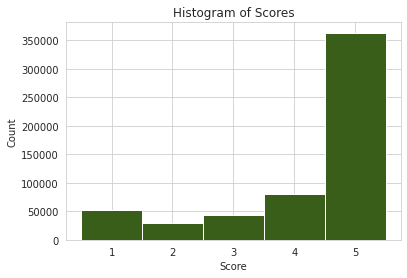

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

sns.histplot(df['Score'], discrete=True, alpha=1, color='#395E1A')
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

 This is a left skewed bimodal distribution with having peak review scores at 5 and 1.

# 2. Classify Reviews as Positive, Negative, or Neutral

In [ ]:
# Reviews with scores 1 or 2 are labeled as 0 (negative)
# Reviews with score 3 are labeled as 1 (neutral)
# Reviews with scores 4 or 5 are labeled as 2 (positive)
df['label'] = df['Score'].apply(lambda x: 2 if x>=4 else(0 if x<=2 else 1))

### 2.1 Plot the distribution of reviews

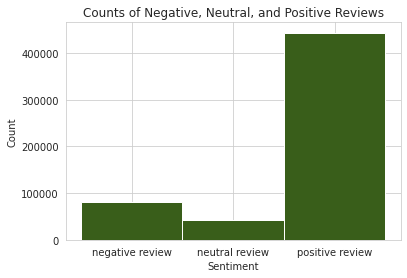

In [ ]:
plt.title('Counts of Negative, Neutral, and Positive Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['negative review', 'neutral review', 'positive review'])
sns.histplot(df['label'], discrete=True, alpha=1, color='#395E1A')
plt.show()

Once again there are imbalanced class distributions. Resampling methods should be explored in the future.

# 3. Feature Engineering

### 3.1 Dropping null value and the Score column

In [ ]:
df_new = df.copy()
df_new.dropna(inplace=True)
df_new.drop('Score', axis=1, inplace=True)

### 3.2 Remove all non-letter characters to isolate words to prepare for word bagging

In [ ]:
# Remove Punctuation from text
def remove_non_letters(s):
  # Use a regular expression to match all non-letter characters (and spaces)
  import re
  pattern = re.compile(r'[^a-zA-Z\s]')
  return pattern.sub('', s)

df_new['Summary'] = df_new['Summary'].apply(remove_non_letters)
df_new['Text'] = df_new['Text'].apply(remove_non_letters)
df_new['full_text'] = df_new['Summary'] + ' ' + df_new['Text']
df_new.drop(columns=['Summary', 'Text'], inplace=True)

### 3.3 Splitting Training and Testing data

In [ ]:
from sklearn.model_selection import train_test_split

# Features and target for Logistic Regression
# Keep training time at a minimum. This is still roughly 150,000 reviews
df_lr = df_new.sample(frac=0.05, random_state=0)
X_lr = df_lr.copy()
y_lr = X_lr.pop('label')
X_lr = X_lr.astype('string')
# Features and target for Naive Bayes
X_nb = df_new.copy()
y_nb = X_nb.pop('label')
X_nb = X_nb.astype('string')

# Split the data into training and test sets
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(X_nb, y_nb, test_size=0.2, random_state=0)

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=0)

# 4. Apply the Logistic Regression Model and Multinomial Naive Bayes Classifier with Counter Vectorizer

### 4.1 Create Pipeline for Count Vectorization and Logistic Regression



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

bow = CountVectorizer()
logr = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state=0)

cv_lr_pipe = Pipeline([
    ('bag_of_words', bow),
    ('logistic regression', logr)
])

cv_lr_pipe.fit(X_lr_train['full_text'], y_lr_train)

Pipeline(steps=[('bag_of_words', CountVectorizer()),
                ('logistic regression',
                 LogisticRegression(multi_class='multinomial', random_state=0,
                                    solver='newton-cg'))])

### 4.2 Create Pipeline for Count Vectorization and Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

bow = CountVectorizer()
mn_nb = MultinomialNB()

cv_nb_pipe = Pipeline([
    ('bag_of_words', bow),
    ('naive bayes', mn_nb)
])

cv_nb_pipe.fit(X_nb_train['full_text'], y_nb_train)

Pipeline(steps=[('bag_of_words', CountVectorizer()),
                ('naive bayes', MultinomialNB())])

### 4.3 Create Predictions with each model

In [ ]:
y_lr_pred = cv_lr_pipe.predict(X_lr_test['full_text'])
y_nb_pred = cv_nb_pipe.predict(X_nb_test['full_text'])

# 5. Assess the Model's Performance

### 5.1 Create and plot the confusion matrix

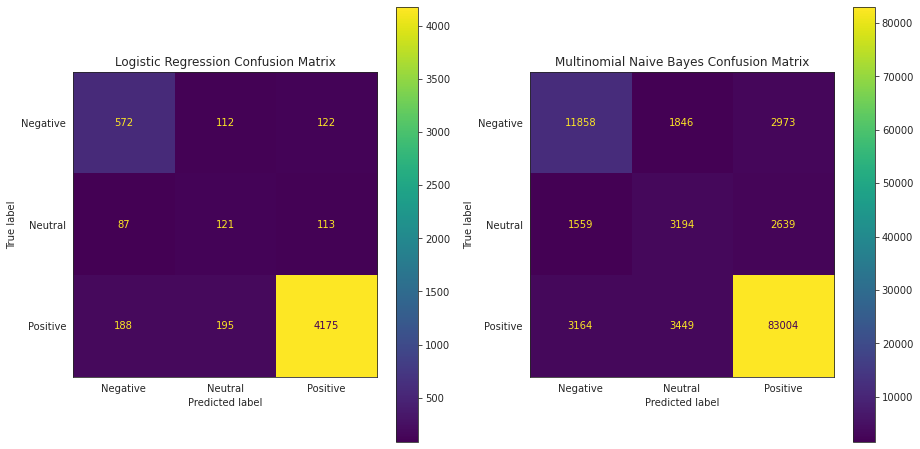

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style('white')

# create a confusion matrix for each model
cm_lr = confusion_matrix(y_lr_pred,y_lr_test)
cm_nb = confusion_matrix(y_nb_pred,y_nb_test)

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Create a ConfusionMatrixDisplay object
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['Negative', 'Neutral', 'Positive'])
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=['Negative', 'Neutral', 'Positive'])

# Plot and Fromatting
ax[0].set_title('Logistic Regression Confusion Matrix')
disp_lr.plot(ax=ax[0])
ax[1].set_title('Multinomial Naive Bayes Confusion Matrix')
disp_nb.plot(ax=ax[1])

plt.show()

See results at the beginning for analysis.

### 5.2 Visualize the Classificaiton Report

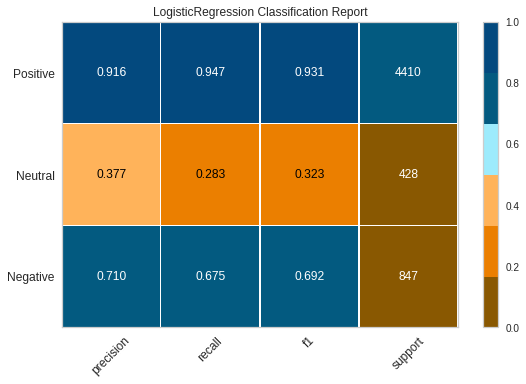

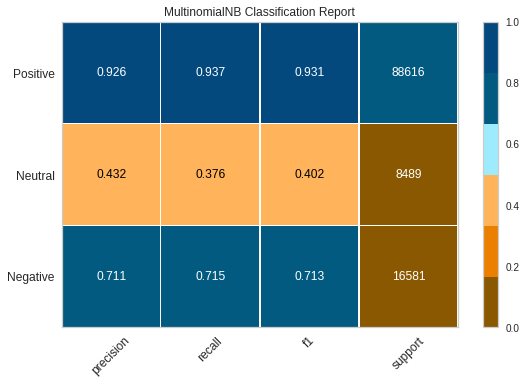

In [ ]:
from yellowbrick.classifier import classification_report
bo_gradient = ['#895801', '#EB7F00', '#ffb35a', '#9DEBFC', '#035a80', '#03497E']

# Create a ClassificationReport object for Logistic Regression
visualizer = classification_report(cv_lr_pipe, X_lr_train['full_text'], y_lr_train, X_lr_test['full_text'], y_lr_test, classes=['Negative', 'Neutral', 'Positive'], support=True, cmap=bo_gradient)

# Create a ClassificationReport object for Naive Bayes
visualizer2 = classification_report(cv_nb_pipe, X_nb_train['full_text'], y_nb_train, X_nb_test['full_text'], y_nb_test, classes=['Negative', 'Neutral', 'Positive'], support=True, cmap=bo_gradient)


See results at the beginning for analysis.

# 6. Save the Models

In [ ]:
import pickle
# Serialize the model object and write it to a file
pickle.dump(cv_lr_pipe, open('/content/drive/MyDrive/models/cv_lr_pipe.pkl', 'wb'))
pickle.dump(mn_nb, open('/content/drive/MyDrive/models/mn_nb.pkl', 'wb'))